In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers.normalization_v2 import BatchNormalization
import numpy as np

In [18]:
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0],True)

In [19]:
# Constants
BATCH_SIZE = 64
IMAGE_SIZE = 120
Channel = 1
Epochs = 5
n_class = 4

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1)

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/COVID-19_Radiography_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')
class_names = dataset.class_names

Found 21165 files belonging to 4 classes.


In [21]:
def get_dataset_partition(dataset,train_split=0.98,dev_split=0.02,shuffle=True, shuffle_size=10000):
    assert (train_split + dev_split) == 1
    data_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * data_size)

    train_data = dataset.take(train_size)
    dev_data = dataset.skip(train_size)
    return train_data, dev_data

In [22]:
def cnn_model_mod2(train_data,dev_data):
    
    resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
    ])
    augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
    ])
    
    # Dropout at the input layer is not required.

    # As the filter increase we would try to increase the dropout rate.
    model = models.Sequential([
        resize_rescale, augmentation,
        layers.Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(n_class, activation='softmax')
    ])
    model.build(input_shape=input_shape)

    model.summary()
    inital_learning_rate = 0.1

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=inital_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    history = model.fit(train_data,batch_size=BATCH_SIZE,validation_data=dev_data,verbose=1,epochs=Epochs)


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    return acc,val_acc,loss,val_loss


In [23]:
def cnn_model_mod2_decay_learning(train_data,dev_data):
    
    resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
    ])
    augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
    ])
    
    # Dropout at the input layer is not required.

    # As the filter increase we would try to increase the dropout rate.
    model = models.Sequential([
        resize_rescale, augmentation,
        layers.Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(n_class, activation='softmax')
    ])
    model.build(input_shape=input_shape)

    model.summary()

    inital_learning_rate = 0.1

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(inital_learning_rate,decay_steps=100000,decay_rate=0.96,staircase=True)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    history = model.fit(train_data,batch_size=BATCH_SIZE,validation_data=dev_data,verbose=1,epochs=Epochs)


    acc_d = history.history['accuracy']
    val_acc_d = history.history['val_accuracy']

    loss_d = history.history['loss']
    val_loss_d = history.history['val_loss']

    return acc_d,val_acc_d,loss_d,val_loss_d

In [24]:
train_data, dev_data = get_dataset_partition(dataset,train_split=0.98,dev_split=0.02,shuffle=True)

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_data = dev_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
acc,val_acc,loss,val_loss = cnn_model_mod2(train_data,dev_data)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
sequential_4 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (64, 120, 120, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (64, 120, 120, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (64, 60, 60, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (64, 60, 60, 64)          18496     
_________________________________________________________________
batch_normalization_7 (Batch (64, 60, 60, 64)         

In [26]:
acc_d,val_acc_d,loss_d,val_loss_d = cnn_model_mod2_decay_learning(train_data,dev_data)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
sequential_7 (Sequential)    (64, 120, 120, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (64, 120, 120, 32)        320       
_________________________________________________________________
batch_normalization_12 (Batc (64, 120, 120, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (64, 60, 60, 32)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (64, 60, 60, 64)          18496     
_________________________________________________________________
batch_normalization_13 (Batc (64, 60, 60, 64)         

In [31]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

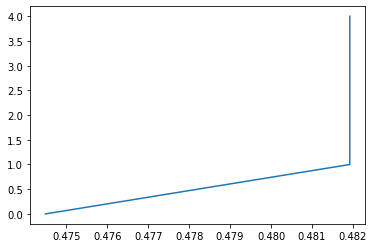